In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
plt.rcParams.update({'font.size': 12})
import seaborn as sns
import cmath
import math 
from numpy.linalg import inv
def custom_plot_single(x_lst, y_lst, label_lst, xlim, ylim, label,pltname,
                       color=['k','r','b','g','o','br'],
                       linestyle=['solid','dashed','solid','dashed','solid','dashed'],
                       markertype=[None,None,'o','^','o','^'],
                       fillstyle=['none','none','none','none','full','full'],
                       linewidth=20*[3],
                       markevery=[45,30,50,40,56,72,63,95],
                       show_legend=True,
                       plt_outside=False):
    
    fig, ax1 = plt.subplots(1,1)
    fig.set_size_inches(10,10)
    fig.patch.set_facecolor('white')
    ax1.patch.set_facecolor('white')
    for p in range(0, len(x_lst)):
        ax1.plot(x_lst[p], y_lst[p], color[p],
                 linewidth=linewidth[p],
                 linestyle=linestyle[p],
                 marker=markertype[p],
                 fillstyle=fillstyle[p],
                 markevery=markevery[p],
                 markersize=8,
                 label=label_lst[p])
    if(show_legend):
        ax1.legend(prop={'size': 20},loc='best')
    ax1.tick_params(which='minor', width=2, length=4, color='k')
    ax1.tick_params(which='major', width=2, length=8, color='k')

    ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    if(show_legend):
        ax1.legend(prop={'size': 20},loc='best')#,shadow=True)

    ax1.set_ylim(ylim[0],ylim[1])
    ax1.set_xlim(xlim[0],xlim[1])
    ax1.set_xlabel(label[0], fontsize=25)#, fontdict=dict(weight='bold'))
    ax1.set_ylabel(label[1], fontsize=25)#, fontdict=dict(weight='bold'))
    fontsize=25
    for tick in ax1.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)

    for tick in ax1.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    if(plt_outside==False):
        plt.savefig(pltname, bbox_inches = "tight")
    return plt,pltname


In [2]:
PrintFigures=True
PointCharge=True

### parameter definition

In [3]:
h=1.06e-34
q=1.602e-19
G_quantum=2*q**2/h #at zero temperature
print('G_quantum',G_quantum)
print('R_quantum',1/G_quantum)
gamma=2.5 #eV
acc=0.142e-9
m=17
n=0
nano=1e-9

#N=num_layers_ch
#U=avg_field_ch

def get_radius(acc,m,n):
    return acc*(np.sqrt(3.)/(2*np.pi))*np.sqrt(m**2 + m*n + n**2)


R = get_radius(acc,m,n)
print('Radius of CNT (nm):', R/nano)

Eg_min = acc*gamma/R
print('bandgap, H/(eV):', Eg_min)

Us=0.0 #V, Source potential
Ud=0.0 #V, Drain potential

N=4
print('number of layers in the channel: ', N)

q_factor = math.gcd(m, n)
Int=(m-n)/(3*q_factor)
print('q_factor',q_factor)
print('Int',Int)
if(Int.is_integer()):
    d_R = 3*q_factor
else:
    d_R = q_factor
print('d_R',d_R)
Natoms_per_UC=int(4*(m**2+m*n+n**2)/d_R)
print('number of atoms per unit cell',Natoms_per_UC)


if(n==0): #zigzag
    M =  int(Natoms_per_UC/4)
elif(m==n): #armchair
    M = int(Natoms_per_UC/2)
else:
    M = np.abs(m-n)
print('number of total modes or atoms along the ring', M)
M_red = 1
print('number of modes used to construct hamiltonian', M_red)

nring_per_unitcell = 4 #for a zigzag nanotube
print('nring_per_unitcell',nring_per_unitcell)

avg_distance_per_layer = 3*acc/nring_per_unitcell
print('avg_distance_per_layer',avg_distance_per_layer)
print('Total length', N*avg_distance_per_layer)


G_quantum 0.00048422716981132076
R_quantum 2065.1464071907617
Radius of CNT (nm): 0.665453976774103
bandgap, H/(eV): 0.5334704012453583
number of layers in the channel:  4
q_factor 17
Int 0.3333333333333333
d_R 17
number of atoms per unit cell 68
number of total modes or atoms along the ring 17
number of modes used to construct hamiltonian 1
nring_per_unitcell 4
avg_distance_per_layer 1.065e-10
Total length 4.26e-10


### Point Charge

In [4]:
Y_offset = -(N/2)*avg_distance_per_layer #nm
#print('Y_offset',Y_offset)
axial_loc = np.empty(N,dtype=float)

def get_axial_loc(r,ACC):
    y=0.
    if(r % 2 == 0):
        y = ACC
    elif (r%2 == 1):
        y = ACC/2
    return y
 
axial_loc[0]=acc/2.

for l in range(1,N):
    rID_in_unitcell = l%nring_per_unitcell   
#    print(rID_in_unitcell)
    axial_loc[l] = axial_loc[l-1] + get_axial_loc(rID_in_unitcell,acc)
    
for l in range(0,N):
    axial_loc[l] += Y_offset  
    
#print(axial_loc)

U=np.zeros(N)
pt_charge_loc=np.array([0.,1*nano])

Q=-q #C
print('Q',q)
eps_r =1 
eps_0 = 8.85418782e-12 #F/m or C/(V.m)
if (PointCharge):
    for l in range(0, N):
        r = np.sqrt((axial_loc[l]-pt_charge_loc[0])**2 + pt_charge_loc[1]**2)
        U[l] = 1./(4.*np.pi*eps_0*eps_r) * Q/r
        U[l] = 0
print('potential on layers:',U)
Us = U[0]
Ud = U[-1]

Ec0 = Eg_min/2
Ev0 = -Eg_min/2

print('Ec0',Ec0)
print('Ev0',Ev0)

Q 1.602e-19
potential on layers: [0. 0. 0. 0.]
Ec0 0.26673520062267914
Ev0 -0.26673520062267914


### Bandgap (From Theory)

In [5]:

def get_bandgap_for_mode(p,acc,gamma,m,n):
    R=get_radius(acc,m,n)
    Eg_case=np.zeros(6,dtype=float)
    if(p>0):
        Eg_case[0] = (acc*gamma/R)*np.abs(3*p - (2*m+n))
        Eg_case[1] = (acc*gamma/R)*np.abs(3*p - (m+2*n))
        Eg_case[2] = (acc*gamma/R)*np.abs(3*p - (m-n))
        Eg_case[3] = (acc*gamma/R)*np.abs(-3*p + (2*m+n))
        Eg_case[4] = (acc*gamma/R)*np.abs(-3*p + (m+2*n))
        Eg_case[5] = (acc*gamma/R)*np.abs(3*p - (m-n))
    elif(p<0):
        Eg_case[0] = (acc*gamma/R)*np.abs(-3*p - (2*m+n))
        Eg_case[1] = (acc*gamma/R)*np.abs(-3*p - (m+2*n))
        Eg_case[2] = (acc*gamma/R)*np.abs(-3*p - (m-n))
        Eg_case[3] = (acc*gamma/R)*np.abs(3*p + (2*m+n))
        Eg_case[4] = (acc*gamma/R)*np.abs(3*p + (m+2*n))
        Eg_case[5] = (acc*gamma/R)*np.abs(-3*p - (m-n))
     
    Eg = np.amin(Eg_case)
    min_index = np.argmin(Eg_case)
    return (Eg,min_index+1)


m_arranged=np.arange(1,M+1,1)
m_arranged_rev=np.zeros(np.size(m_arranged),dtype=int)
counter=0
for i in reversed(m_arranged):
    m_arranged_rev[counter] = -i
    counter=counter+1
M_arr = np.concatenate((m_arranged_rev,m_arranged))
#M_arr = np.arange(-m+1,m,1)

print('M_arr',M_arr)

Eg_arr = np.zeros(M, dtype=float)
counter=0
for p in range(1,M+1):
    eg, case = get_bandgap_for_mode(p,acc,gamma,m,n)
    Eg_arr[p-1]=eg
    print('mode, bandgap', p , Eg_arr[p-1], case)
    #counter +=1

Eg_min = np.amin(Eg_arr)
print('minimum bandgap, acc*gamma/R',Eg_min, acc*gamma/R)

Eg_min_index_arr = np.where(Eg_arr==Eg_arr.min())
print('band with minimum bandgap:')
for j in Eg_min_index_arr:
    print(M_arr[M+j])
    
sorted_M_arr = [x for _,x in sorted(zip(Eg_arr,np.arange(1,M+1,1)))] 
#print('sorted_M_arr:',sorted_M_arr)
print('size of sorted_M_arr:',np.shape(sorted_M_arr))

M_red_arr = []
#np.zeros(M_red,dtype=int)

M_red_arr.append(sorted_M_arr[0])
i = 1
counter = 1
while(counter < M_red):
    if(Eg_arr[sorted_M_arr[i]-1] != Eg_arr[sorted_M_arr[i-1]-1]):
        M_red_arr.append(sorted_M_arr[i])
        counter +=1
    i += 1
print('M_red_arr',M_red_arr)
M_red_arr[0]=6
print('M_red_arr',M_red_arr)


M_arr [-17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   1
   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17]
mode, bandgap 1 7.468585617435016 2
mode, bandgap 2 5.868174413698941 2
mode, bandgap 3 4.267763209962866 2
mode, bandgap 4 2.6673520062267913 2
mode, bandgap 5 1.0669408024907165 2
mode, bandgap 6 0.5334704012453583 2
mode, bandgap 7 2.133881604981433 2
mode, bandgap 8 3.734292808717508 2
mode, bandgap 9 3.734292808717508 1
mode, bandgap 10 2.133881604981433 1
mode, bandgap 11 0.5334704012453583 1
mode, bandgap 12 1.0669408024907165 1
mode, bandgap 13 2.6673520062267913 1
mode, bandgap 14 4.267763209962866 1
mode, bandgap 15 5.868174413698941 1
mode, bandgap 16 7.468585617435016 1
mode, bandgap 17 9.06899682117109 1
minimum bandgap, acc*gamma/R 0.5334704012453583 0.5334704012453583
band with minimum bandgap:
[ 6 11]
size of sorted_M_arr: (17,)
M_red_arr [6]
M_red_arr [6]


### Band structure and First Brillouin Zone


counter,p 2 5
counter,p 3 12
counter,p 4 7
counter,p 5 10
counter,p 6 4
counter,p 7 13
counter,p 8 8
counter,p 9 9
counter,p 10 3
counter,p 11 14
counter,p 12 2
counter,p 13 15
counter,p 14 1
counter,p 15 16
counter,p 16 17
size of E_k (34, 2401)


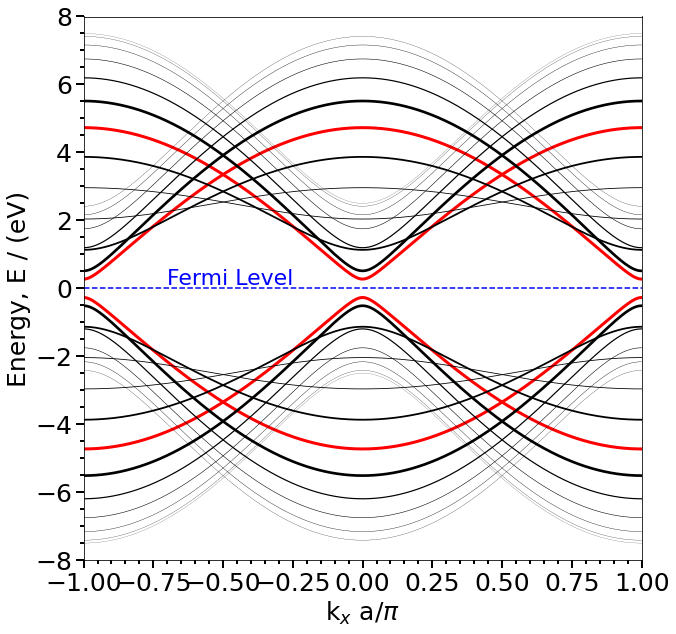

In [6]:
def get_dispersion(m,gamma,nu,E_nu,kxa_arr):
    kyb=2*np.pi*nu/(2*m)
    for kxa in kxa_arr:
        E_nu.append(gamma*np.sqrt(1+(4*np.cos(kyb)*np.cos(kxa))+(4*np.cos(kyb)**2)))

k_pi=np.linspace(-np.pi,np.pi,2401) # range*pi    
k = k_pi/np.pi

nu_label=str(sorted_M_arr)
#print(nu_label)
E_k=[]
linecolor=[]
linewidth=[]
counter=0
lw=3
lc='r'

for p in sorted_M_arr:
    E_nu=[]
    get_dispersion(m,gamma,p,E_nu,k_pi)
    E_k.append(E_nu)
    E_nu_inv = []
    for i in range(0,len(k)):
        E_nu_inv.append(-1*E_nu[i])
    E_k.append(E_nu_inv)
    if(counter > 1):
        print('counter,p',counter,p)
        lc='k'  
    linecolor.append(lc)
    linecolor.append(lc)
    
    linewidth.append(lw)
    linewidth.append(lw)
    counter += 1
    if (counter%2 == 0):
        lw=4*np.exp(-0.2*counter)

print('size of E_k',np.shape(E_k))

if(PrintFigures):
    plt,pltname = custom_plot_single(2*M*[k], 
                       E_k,
                       2*M*[None],
                       [-1,1],[-8,8],[r'k$_x$ a/$\pi$',r'Energy, E / (eV)'],'Dispersion_all.png',
                       linecolor,
                       2*M*['solid'],
                       2*M*[None],
                       2*M*['none'],
                       linewidth,2*M*['none'],
                       show_legend=False,
                       plt_outside=True)
    plt.axhline(y = 0., color = 'b', linestyle = 'dashed',label='Fermi')
    plt.text(-0.7, 0.1, 'Fermi Level', fontsize=22,color='b')
    plt.savefig(pltname, bbox_inches = "tight")


p2 11
gamma 2.5 1.42e-10 6.65453976774103e-10
minimum band gap: (eV) 0.5334704012453583


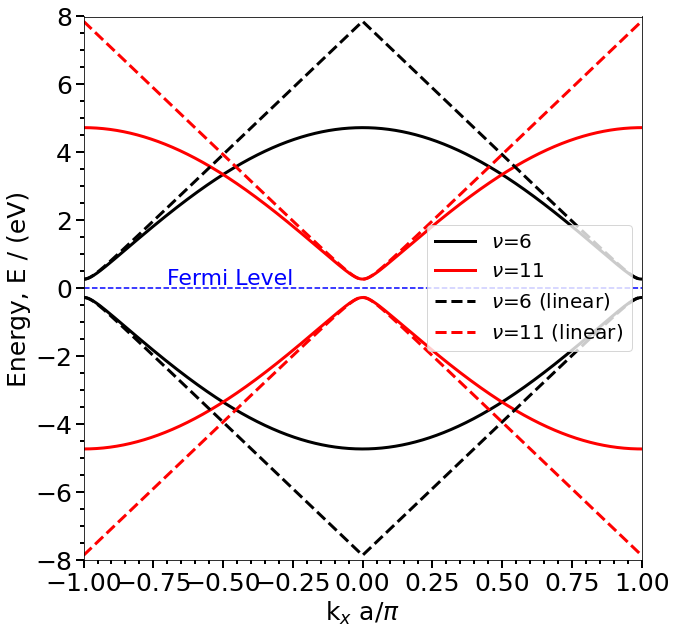

In [7]:
import operator
p1=sorted_M_arr[0]
p2=sorted_M_arr[1]
print('p2',p2)

Eg = gamma*acc/R
print('gamma',gamma,acc,R)
a=3*acc/2 
b=np.sqrt(3)*acc/2

def get_linear_approximate_dispersion(m,gamma,nu,E_nu,kxa_arr,kf):
    kyb=2*np.pi*nu/(2*m)
    factor=-1
    for kxa in kxa_arr:
        if(kxa > 0):
            factor =1
        E_nu.append((3*gamma/2)*np.sqrt((kxa*2/3-factor*kf[0]*acc)**2 + ((kyb*2/np.sqrt(3)-kf[1]*acc))**2))      

kf=[np.pi/a, np.pi/(3*b)]
E_lin_1 = []
get_linear_approximate_dispersion(m,gamma,p1,E_lin_1,k*np.pi,kf)
E_lin_1_minus=list(map(operator.mul, E_lin_1, [-1]*len(E_lin_1))) #multiply all elements in list by -1

kf=[0, 2*np.pi/(3*b)]
E_lin_2 = []
get_linear_approximate_dispersion(m,gamma,p2,E_lin_2,k*np.pi,kf)
E_lin_2_minus=list(map(operator.mul, E_lin_2, [-1]*len(E_lin_2))) #multiply all elements in list by -1

if(PrintFigures):
    plt,pltname=custom_plot_single([k,k,k,k,k,k,k,k], 
                       [E_k[2*1-2],E_k[2*1-1],E_k[2*2-2],E_k[2*2-1],
                        E_lin_1,E_lin_1_minus,E_lin_2, E_lin_2_minus],
                       [r'$\nu$='+str(int(p1)),None, r'$\nu$='+str(int(p2)), None, r'$\nu$='+str(int(p1))+' (linear)',None, r'$\nu$='+str(int(p2))+' (linear)',None],
                       [-1,1],[-8,8],[r'k$_x$ a/$\pi$',r'Energy, E / (eV)'],'Dispersion.png',
                       ['k','k','r','r','k','k','r','r'],
                       ['solid','solid','solid','solid','dashed','dashed','dashed','dashed'],
                       8*[None],
                       8*['none'],
                       plt_outside=True)
    
    plt.axhline(y = 0., color = 'b', linestyle = 'dashed',label='Fermi')
    plt.text(-0.7, 0.1, 'Fermi Level', fontsize=22,color='b')
    plt.savefig(pltname, bbox_inches = "tight")
    
print('minimum band gap: (eV)', Eg)

### Construct hamiltonian H

In [8]:
#The following 2 functions are to create off-diagonal elements of a hamiltonian
def get_zeros_and_ones(L,lst):
    for i in range(0,L):
        if(i%2==0):
            lst.append(0)
        else:
            lst.append(1)
            
def get_ones_and_zeros(L, lst): 
    for i in range(0,L):
        if(i%2==0):
            lst.append(1)
        else:
            lst.append(0)

lst_01 = [] 
lst_10 = [] 

get_zeros_and_ones(N-1, lst_01)
get_ones_and_zeros(N-1, lst_10)

def get_beta(gamma, M, J): #overlap coefficient in mode-space approximation
    return 2*gamma*np.cos(np.pi*J/M) #*np.exp(-1j*np.pi*J/M)

In [9]:
print(M_red_arr[0])
print(get_beta(gamma,M,11))

6
-2.228691778882689


(1, 4, 4)
(4, 4)


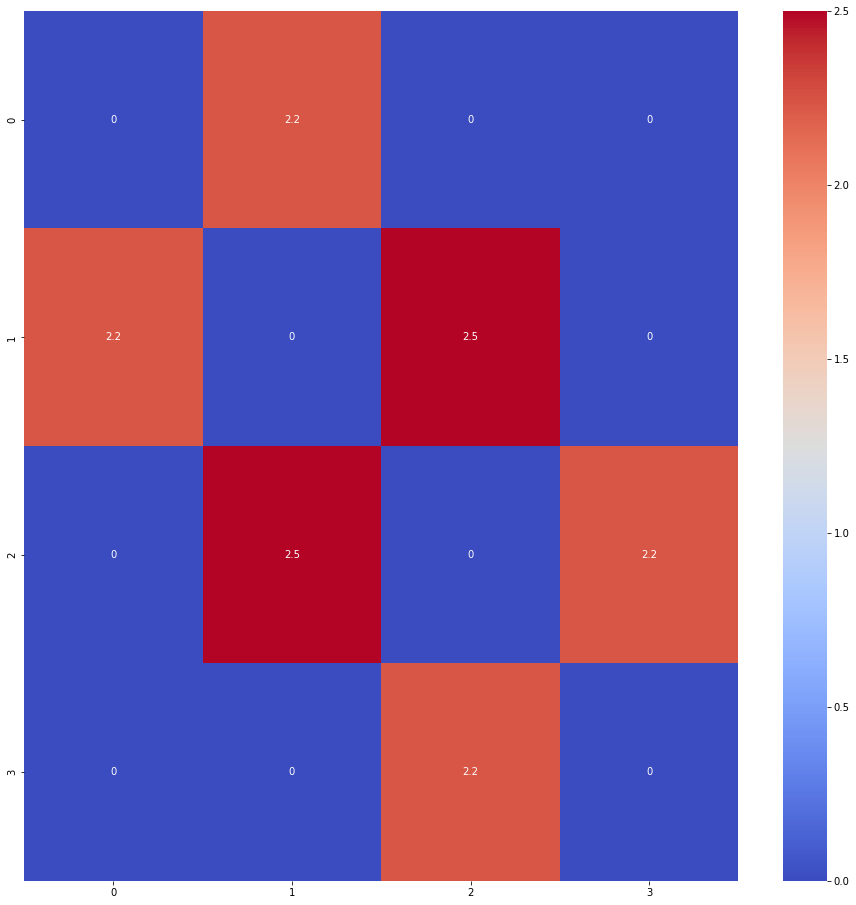

In [10]:
H_mode=np.zeros((M_red,N,N),dtype=float)
print(np.shape(H_mode))
zero_mat=np.zeros((N,N),dtype=float)
#print(np.shape(zero_mat))
H=np.zeros((M_red*N,M_red*N),dtype=float)
print(np.shape(H))
beta = np.zeros(M_red,dtype=float)

for i in range(0,M_red):
    p=M_red_arr[i]
    beta[i] = get_beta(gamma,M,p)
    H_mode[i] =U*np.diag(np.ones(N)) + gamma*np.diag(lst_01,-1)  + beta[i]*np.diag(lst_10,-1) \
    + gamma*np.diag(lst_01,1) + beta[i]*np.diag(lst_10,1) 

H_lst=[]
for i in range (0, M_red):
    submat = []
    for j in range(0, M_red):
        if j==i:
            submat.append(H_mode[i])
        else:
            submat.append(zero_mat)          
    H_lst.append(submat)
H=np.block(H_lst)

if(PrintFigures):
    plt.figure(figsize = (16,16))
    sns.heatmap(H,cmap='coolwarm',annot=True)

In [11]:
def get_analytical_retarted_surface_GF(E, U,gamma,beta_j,Print):
    #zplus = 1j*1e-14
    #EmU=E+zplus-U
    EmU = E-U
    Factor=EmU**2 + gamma**2 - beta_j**2
    Sqrt=cmath.sqrt(Factor**2 - 4 * EmU**2 * gamma**2)
    Denom = 2 * gamma**2 * EmU

    Numer1= (Factor + Sqrt)
    Numer2= (Factor - Sqrt)
  
    if(Print):
        print('E,U,gamma,beta_j',E,U,gamma,beta_j)
        print('*',4 * EmUs**2 * gamma**2/Factor**2)
        print('Sqrt',Sqrt)
        print('Denom',Denom)
        print('Numer1',Numer1)
        print('Numer2',Numer2)
        print(np.imag(Numer1),np.imag(Numer2))

    #zplus=1j*1e-8 #small imaginary number

    val1 = Numer1/Denom #- zplus
    val2 = Numer2/Denom #- zplus
#     val = 0. + 1j*0.
#     if(np.imag(val1) < 0.):
#         val = val1 
#     elif (np.imag(val2) < 0.):
#         val = val2 
        
    if(Print): print(val)
    return val1

### define E-space


In [12]:
import numpy.polynomial.legendre as GL
def nf(E,kT=0.025,eta=None): 
    """ The Fermi distribution """
    if eta is None:
        # Ensures that numpy does not do anything with complex numbers!
        return 1./( np.exp( E / kT ) + 1 )
    return 1./( np.exp( (E+1j*eta) / kT) + 1)

def maxis(axs,**kwargs):
    """ Shorthand for setting several parameters for the axis environment """
    if isinstance(axs,(list,np.ndarray)):
        for ax in axs: 
            maxis(ax,**kwargs)
        return
    tmp = kwargs.get('xlbl',None)
    if tmp: axs.set_xlabel(tmp)
    tmp = kwargs.get('ylbl',None)
    if tmp: axs.set_ylabel(tmp)
    tmp = kwargs.get('title',None)
    if tmp: axs.set_title(tmp)
    tmp = kwargs.get('xrng',None)
    if not tmp is None: axs.set_xlim(tmp)
    tmp = kwargs.get('yrng',None)
    if not tmp is None: axs.set_ylim(tmp)

In [392]:
# Emin=-1.00 #eV
# Emax=1.00 #eV
# Epts=1000

# E=np.linspace(Emin,Emax,Epts,dtype=float)

k=8.617333262e-5 #eV/K
Temp=4*298#K
kT = k*Temp
pikT= np.pi*kT
zplus = 1e-8
Ef=0
print('Us', Us)
print('Ud', Ud)
mu_s=Ef + Us
mu_d=Ef + Ud 
mu_c = Ef
print('mu_c',mu_c)

Ei0=2
num_poles=int((Ei0-pikT)/(2.0*pikT)+1)
print('poles',num_poles)
enclosed_poles = kT * np.pi * (2 * np.arange(num_poles) + 1)
print(enclosed_poles)

zeta = 2*num_poles*pikT
print('zeta',zeta)
eta = -20*kT
print('eta',eta)
E_left = -12 #eV
E_right= 1
E_cent = 0.
R = 0.
zplus=1e-8

E_path2plus_pts = 80
E_path1plus_pts = 80
E_path0plus_pts = 20
E_total_pts = E_path0plus_pts + E_path1plus_pts + E_path2plus_pts

# f_s=1./(1.+np.exp((E-mu_s)/(k*Temp)))
# f_d=1./(1.+np.exp((E-mu_d)/(k*Temp)))
# f_c=1./(1.+np.exp((E-mu_c)/(k*Temp)))
# print(mu_s, mu_d, mu_c)

# dfdE_s = np.gradient(f_s)
# dfdE_d = np.gradient(f_d)
# dfdE_c = np.gradient(f_c)

Us 0.0
Ud 0.0
mu_c 0
poles 3
[0.32270004 0.96810012 1.61350019]
zeta 1.9362002301819317
eta -2.0543722496608


In [393]:
def CircularArc_plus(zeta, eta, E_left, zplus, N=100):
    
    E_center = (E_left**2 - zeta**2 - eta**2)/(2*(E_left - eta))
    
    R = E_center - E_left
    X_lst = []
    Y_lst = []
    theta1 = np.arcsin(zeta/R)
    theta2 = np.pi
    
    for n in range(0,N+1):
        X_lst.append(E_center+R*math.cos(theta1+((theta2-theta1)*n/N)))
        Y_lst.append(zplus+R*math.sin(theta1+((theta2-theta1)*n/N))) 
    X_arr = np.asfarray(X_lst)
    Y_arr = np.asfarray(Y_lst)

    return (X_arr,Y_arr)

circleplus_x, circleplus_y = CircularArc_plus(zeta, eta, E_left,zplus, N=100)


def Path2_plus(zeta, eta, E_left,zplus, deg=41):
    
    E_center = (E_left**2 - zeta**2 - eta**2)/(2*(E_left - eta))
    R = E_center - E_left
    print('E_cent', E_center)
    print('radius, R',R)

    theta1 = np.arcsin(zeta/R)
    theta2 = np.pi #2*np.pi-np.arcsin(zeta/R)
    print('theta1:',theta1, R*math.sin(theta1))
    
    # using np.leggauss() method 
    x,w = GL.leggauss(deg) 
    
    a_r=eta
    b_r=E_left
    a_i=zeta
    b_i=zplus
    
    theta = x*(theta2-theta1)/2. + (theta2 + theta1)/2
    t_r = E_center+R*np.cos(theta)
    t_i = zplus+R*np.sin(theta)
    factor = ((theta2-theta1)/2.)*R*np.exp(1j*theta)*1j
    return(E_center, R, t_r, t_i, w, factor)

Eplus_cent, path2_R, path2plus_x, path2plus_y, path2plus_weight, path2plus_factor_arr = Path2_plus(zeta, eta, E_left,zplus,deg=E_path2plus_pts)

def Path1_plus(zeta,eta,E_right,deg=11):
    x,w = GL.leggauss(deg)     

    t_r = (eta-E_right)*0.5*x + (eta+E_right)*0.5
    t_i = zeta*np.ones(deg)
    factor = (eta-E_right)/2.
    return (t_r, t_i, w, factor)

path1plus_x, path1plus_y, path1plus_weight, path1plus_factor = Path1_plus(zeta,eta,E_right,deg=E_path1plus_pts)

# def Path2_plus(zeta, eta, E_left,zplus, deg=41):
    
#     x,w = GL.leggauss(deg) 
    
#     t_r = E_left*np.ones(deg)
#     t_i = (zplus-zeta)*0.5*x + (zeta+zplus)*0.5
#     factor = 1j*(zplus-zeta)*0.5
#     return (t_r, t_i, w, factor)
#     return(E_center, R, t_r, t_i, w, factor)

# path2plus_x, path2plus_y, path2plus_weight, path2plus_factor = Path2_plus(zeta,eta,E_left,zplus,deg=E_path2plus_pts)


# def Path1_plus(zeta,E_left,E_right,deg=11):
#     x,w = GL.leggauss(deg)     

#     t_r = (E_left-E_right)*0.5*x + (E_left+E_right)*0.5
#     t_i = zeta*np.ones(deg)
#     factor = (E_left-E_right)/2.
#     return (t_r, t_i, w, factor)

# path1plus_x, path1plus_y, path1plus_weight, path1plus_factor = Path1_plus(zeta,E_left,E_right,deg=E_path1plus_pts)


def Path0_plus(zeta,eta,E_right,zplus,deg=11):
    x,w = GL.leggauss(deg) 
    
    t_r = E_right*np.ones(deg)
    t_i = (zeta-zplus)*0.5*x + (zeta+zplus)*0.5
    factor = 1j*(zeta-zplus)*0.5
    return (t_r, t_i, w, factor)

path0plus_x, path0plus_y, path0plus_weight, path0plus_factor = Path0_plus(zeta,eta,E_right,zplus,deg=E_path0plus_pts)


E_cent -6.838717813655737
radius, R 5.161282186344263
theta1: 0.38454713746756986 1.9362002301819319


In [394]:
Eplus = np.zeros(E_total_pts,dtype=complex)
weight = np.zeros(E_total_pts,dtype=complex)
factor = np.zeros(E_total_pts,dtype=complex)

for i in range(0, len(path0plus_x)):
    Eplus[i]  = path0plus_x[i] + 1j* path0plus_y[i]
    weight[i]  = path0plus_weight[i]
    factor[i] = path0plus_factor

for i in range(0, len(path1plus_x)):
    Eplus[i+len(path0plus_x)]  = path1plus_x[i] + 1j* path1plus_y[i]
    weight[i+len(path0plus_x)]  = path1plus_weight[i]
    factor[i+len(path0plus_x)]  = path1plus_factor
    
for i in range(0, len(path2plus_x)):
    Eplus[i+len(path0plus_x)+len(path1plus_x)] = path2plus_x[i] + 1j* path2plus_y[i]
    weight[i+len(path0plus_x)+len(path1plus_x)] =  path2plus_weight[i]
    factor[i+len(path0plus_x)+len(path1plus_x)]  = path2plus_factor_arr[i]
#    print(i,factor[i+len(path0plus_x)+len(path1plus_x)] )


# for i in range(0, E_total_pts):
#     print(i, E[i])

# f_s=1./(1.+np.exp((E-mu_s)/(k*Temp)))
# f_d=1./(1.+np.exp((E-mu_d)/(k*Temp)))
# f_c=1./(1.+np.exp((E-mu_c)/(k*Temp)))
# print(mu_s, mu_d, mu_c)

# dfdE_s = np.gradient(f_s)
# dfdE_d = np.gradient(f_d)
# dfdE_c = np.gradient(f_c)

f_paths_plus = np.zeros(E_total_pts,dtype=complex)
for i in range(0, E_total_pts): 
    f_paths_plus[i] = nf(Eplus[i].real, eta=Eplus[i].imag, kT=kT)
    
#print(f_path1n2)

In [395]:
x_label = np.array([E_left, E_right, E_right, eta])
y_label = np.array([zplus, zplus, zeta, zeta])
labels = np.array([r"$z_a$", r"$z_b$", r"$z_c$", r"$z_d$"])

[0.32270004 0.96810012 1.61350019 2.25890027 2.90430035 3.54970042
 4.1951005  4.84050058 5.48590065 6.13130073 6.77670081 7.42210088]
1.9362002301819317


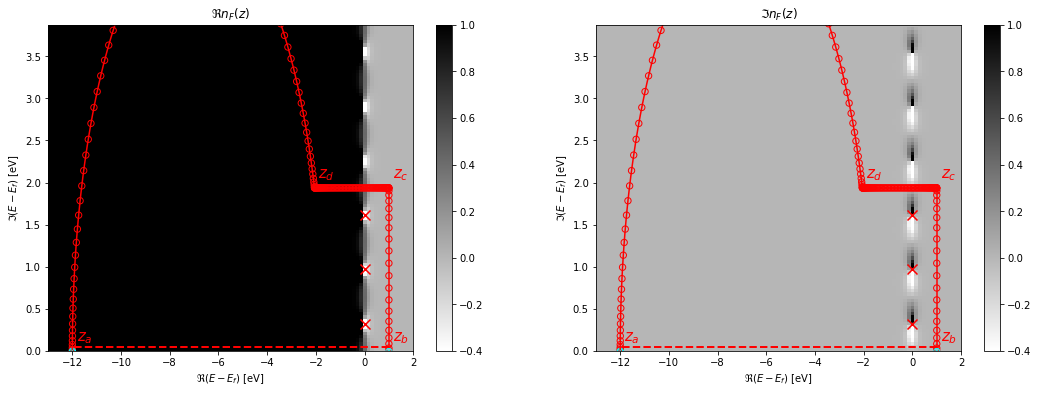

In [396]:
E_contour_pts=100
E_min = E_left-1
E_max = E_right+1
E_real=np.linspace(E_min,E_max,E_contour_pts,dtype=float)

E_complex_y_max = 2*zeta
E_complex = np.linspace(-E_complex_y_max, E_complex_y_max, 2*E_contour_pts)
# Setup the poles
poles = kT * np.pi * (2 * np.arange(int(E_complex_y_max/(pikT))) + 1)
print(poles)

# Calculate the Fermi function
nF = np.empty([len(E_complex), len(E_real)], np.complex128)
for i,e_i in enumerate(E_complex): 
    nF[i,:] = nf(E_real, eta=e_i, kT=kT)
    

fig, axs = plt.subplots(ncols=2, figsize=(18,6))
maxis(axs[0], title=r'$\Re n_F(z)$') ; maxis(axs[1], title=r'$\Im n_F(z)$')
maxis(axs, xlbl='$\Re (E-E_f)$ [eV]', xrng=[np.amin(E_real), np.amax(E_real)],
      ylbl='$\Im (E-E_f)$ [eV]', yrng=[0, np.amax(E_complex)])

L = zeta
print(L)


for i,data in enumerate([nF.real, nF.imag]):
    p = axs[i].pcolor(E_real, E_complex, data, cmap='binary', vmin=-0.4, vmax=1)
    fig.colorbar(p, ax=axs[i])
    
    #upper half plane
    axs[i].scatter(np.zeros(len(enclosed_poles)), enclosed_poles, marker="x", color='r', s=100)


    #axs[i].text(Eplus_cent*1.1,0.15,'R+',color='r')
    axs[i].plot([E_right, E_left], [zplus+0.05,zplus+0.05], 'r--', lw=2)
    
    #axs[i].text(E_right*0.6,(zeta/2),'0+',color='r')
    axs[i].plot([E_right, E_right],[zplus+0.05,zeta], 'r')
    
    #axs[i].text((E_right+eta)/2.,1.1*zeta,'1+',color='r')
    axs[i].plot([E_right, eta], [zeta, zeta], 'r')
    
    
    #axs[i].text(Eplus_cent*1.1,1.1*R,'2+',color='r')
    axs[i].plot(circleplus_x, circleplus_y,color='r')
    
    axs[i].scatter(Eplus.real, Eplus.imag, facecolors='none', edgecolors='r',  s=40)

    #lower half plane
    axs[i].scatter(np.zeros(len(enclosed_poles)), -np.conjugate(enclosed_poles), marker="x", color='aqua', s=100)
    
    #axs[i].text(Eplus_cent*1.1,-0.4,'R-',color='aqua')
    axs[i].plot([E_right, E_left], [-zplus-0.05,-zplus-0.05], 'aqua', linestyle='dashed', lw=2)
    
    #axs[i].text(E_right*0.8,-(zeta/2),'0-',color='aqua')
    axs[i].plot([E_right, E_right],[-zplus-0.05,-zeta], 'aqua')

    #axs[i].text((E_right+eta)/2.,-1.2*zeta,'1-',color='aqua')
    axs[i].plot([E_right, eta], [-zeta, -zeta], 'aqua')

    #axs[i].text(np.conjugate(Eplus_cent)*1.1,-1.2*R,'2-',color='aqua')
    axs[i].plot(circleplus_x, -circleplus_y,color='aqua')

    axs[i].scatter(Eplus.real, -Eplus.imag, facecolors='none', edgecolors='aqua', s=40)


    # zip joins x and y coordinates in pairs
    counter=0
    for x,y in zip(x_label, y_label):
        label = labels[counter]
        axs[i].annotate(label, # this is the text
                     (x,y), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=(12,10), # distance from text to points (x,y)
                     ha='center',color='r',fontsize=15)
        counter +=1

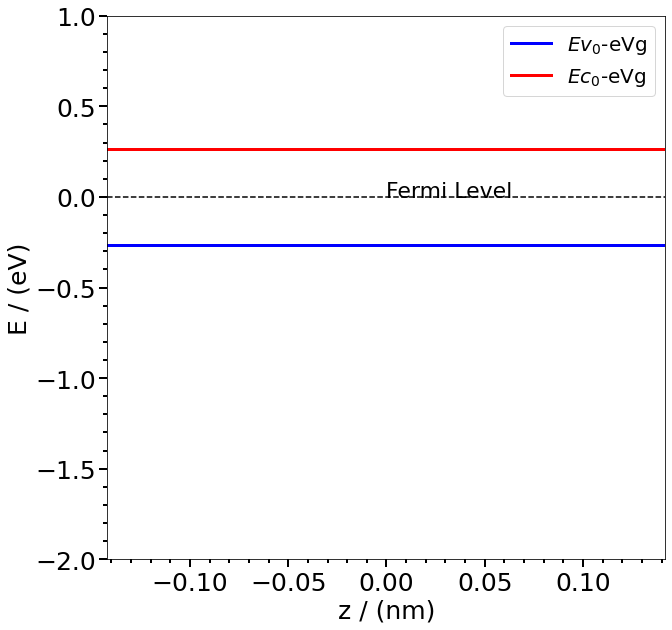

In [397]:
if(PrintFigures):
    plt,pltname = custom_plot_single([axial_loc/nano,axial_loc/nano], 
                       [Ev0+U, Ec0+U],
                       [r'$Ev_0$-eVg', r'$Ec_0$-eVg'],
                       [axial_loc[0]/nano,axial_loc[-1]/nano],[-2,1],[r'z / (nm)',r'E / (eV)'],'Ec0_Ev0_minus_U.png',
                       ['b','r'],linestyle=['solid','solid'],
                       show_legend=True,
                       plt_outside=True)
    plt.axhline(y = Ef, color = 'k', linestyle = 'dashed',label='Fermi')
    plt.text(0, Ef, 'Fermi Level', fontsize=22,color='k')
#    plt.text(-0.1, (Ev0), 'U=-eVg = 0.2 eV; Vg = -0.2 eV', fontsize=22,color='b')

#    plt.axhline(y = Ev0, color = 'b', linestyle = 'dashed',label='Fermi')
#    plt.text(-1, (Ev0), 'Ev0-U(z=10nm)', fontsize=22,color='b')

#    plt.axhline(y = Ec0, color = 'r', linestyle = 'dashed',label='Fermi')
#    plt.text(-1, (Ec0), 'Ec0-U(z=10nm)', fontsize=22,color='r')

#    plt.axhline(y = Ev0-U[-1], color = 'b', linestyle = 'dashed',label='Fermi')
#    plt.text(-1, (Ev0-U[-1]), 'Ev0-U(z=10nm)', fontsize=22,color='b')

#     plt.axhline(y = Ec0-U[-1], color = 'r', linestyle = 'dashed',label='Fermi')
#     plt.text(-9, (Ec0-U[-1]), 'Ec0-U(z=10nm)', fontsize=22,color='r')

#     plt.axhline(y = np.min(Ev0-U), color = 'g', linestyle = 'dashed',label='Fermi')
#     plt.text(-9,  np.min(Ev0-U), 'min(Ev0-U)', fontsize=22,color='g')

    plt.savefig(pltname, bbox_inches = "tight")
    
    
# ##Fermi level
# if(PrintFigures):
#     custom_plot_single([E-Ef,E-Ef,E-Ef], 
#                        [ f_s,f_d,f_c],
#                        [r'source (%.2f V)'%(Us),r'drain (%.2f V)'%(Ud),r'channel (%.f K)'%(Temp)],
#                        [-0.5,0.5],[0,1],[r'Energy, (E - $E_f$) / (eV)',r'Fermi function, f'],'fermi_functions.png',
#                        ['k','r','g'],
#                        ['solid','dashed','solid','dashed'],
#                        ['o','^','o','^'],
#                        4*['none'],
#                        [2,2,2,2])

#     custom_plot_single([E-Ef], 
#                        [-dfdE_c ],
#                        [r'channel (%.f K)'%(Temp)],
#                        [-0.5,0.5],[0,0.1],[r'Energy, (E - $E_f$) / (eV)',r'Gradient of Fermi function, -$\frac{\partial{f}}{\partial{E}}$'],'gradient_of_fermi_functions.png',
#                        ['k','r','k','r'],
#                        ['solid','dashed','solid','dashed'],
#                        ['o','^','o','^'],
#                        4*['none'],
#                        [2,2,2,2])

In [398]:
#contribution from poles along plus and minus imaginary axis

G_R_plus_pole_diag = np.zeros(M_red*N,dtype=complex)
G_A_minus_pole_diag = np.zeros(M_red*N,dtype=complex)


for p in range(0,np.size(enclosed_poles)):
    Sigma_s_plus=np.zeros((M_red*N,M_red*N),dtype=complex)
    Sigma_d_plus=np.zeros((M_red*N,M_red*N),dtype=complex)
    Gamma_s_plus=np.zeros((M_red*N,M_red*N),dtype=complex)
    Gamma_d_plus=np.zeros((M_red*N,M_red*N),dtype=complex)

    Sigma_s_minus=np.zeros((M_red*N,M_red*N),dtype=complex)
    Sigma_d_minus=np.zeros((M_red*N,M_red*N),dtype=complex)
    Gamma_s_minus=np.zeros((M_red*N,M_red*N),dtype=complex)
    Gamma_d_minus=np.zeros((M_red*N,M_red*N),dtype=complex)
    
    for j in range(0,M_red):
        Print=False
        gR_s_plus = get_analytical_retarted_surface_GF(enclosed_poles[p],Us,gamma,beta[j],Print)
        Sigma_s_plus[j*N][j*N] = gamma**2*gR_s_plus
        Gamma_s_plus[j*N][j*N] = -2*np.imag(gamma**2*gR_s_plus)
        
        gR_d_plus = get_analytical_retarted_surface_GF(enclosed_poles[p],Ud,gamma,beta[j],Print)
        Sigma_d_plus[(j+1)*N-1][(j+1)*N-1] = gamma**2*gR_d_plus
        Gamma_d_plus[(j+1)*N-1][(j+1)*N-1] = -2*np.imag(gamma**2*gR_d_plus)
        
        gR_s_minus = get_analytical_retarted_surface_GF(np.conjugate(enclosed_poles[p]),Us,gamma,beta[j],Print)
        Sigma_s_minus[j*N][j*N] = gamma**2*gR_s_minus
        Gamma_s_minus[j*N][j*N] = -2*np.imag(gamma**2*gR_s_minus)
        
        gR_d_minus = get_analytical_retarted_surface_GF(np.conjugate(enclosed_poles[p]),Ud,gamma,beta[j],Print)
        Sigma_d_minus[(j+1)*N-1][(j+1)*N-1] = gamma**2*gR_d_minus
        Gamma_d_minus[(j+1)*N-1][(j+1)*N-1] = -2*np.imag(gamma**2*gR_d_minus)

    G_R_plus_pole_inverse = (enclosed_poles[p]*np.eye(M_red*N))- H - Sigma_s_plus - Sigma_d_plus
    G_R_plus_pole=inv(G_R_plus_pole_inverse)
    G_R_plus_pole_diag += np.diag(G_R_plus_pole)    
    
    G_R_minus_pole_inverse = (np.conjugate(enclosed_poles[p])*np.eye(M_red*N))- H - Sigma_s_minus - Sigma_d_minus
    G_R_minus_pole=inv(G_R_minus_pole_inverse)
    G_A_minus_pole=G_R_minus_pole.conj().T        
    G_A_minus_pole_diag += np.diag(G_A_minus_pole)
    
G_R_plus_pole_diag  = 1j*2*np.pi*kT*G_R_plus_pole_diag
G_A_minus_pole_diag = 1j*2*np.pi*kT*G_A_minus_pole_diag
#print(G_R_plus_pole_diag)


#integrals along L and C for plus and minus contours
rho_plus = np.zeros(M_red*N,dtype=complex)
rho_minus = np.zeros(M_red*N,dtype=complex)

Fermi_plus = 0.+1j*0.
for e in range(0,E_total_pts):
    Sigma_s_plus=np.zeros((M_red*N,M_red*N),dtype=complex)
    Sigma_d_plus=np.zeros((M_red*N,M_red*N),dtype=complex)
    Gamma_s_plus=np.zeros((M_red*N,M_red*N),dtype=complex)
    Gamma_d_plus=np.zeros((M_red*N,M_red*N),dtype=complex)

    Sigma_s_minus=np.zeros((M_red*N,M_red*N),dtype=complex)
    Sigma_d_minus=np.zeros((M_red*N,M_red*N),dtype=complex)
    Gamma_s_minus=np.zeros((M_red*N,M_red*N),dtype=complex)
    Gamma_d_minus=np.zeros((M_red*N,M_red*N),dtype=complex)
    
    for j in range(0,M_red):
        gR_s_plus = get_analytical_retarted_surface_GF(Eplus[e],Us,gamma,beta[j],Print)
        Sigma_s_plus[j*N][j*N] = gamma**2*gR_s_plus
        Gamma_s_plus[j*N][j*N] = -2*np.imag(gamma**2*gR_s_plus)
        
        gR_d_plus = get_analytical_retarted_surface_GF(Eplus[e],Ud,gamma,beta[j],Print)
        Sigma_d_plus[(j+1)*N-1][(j+1)*N-1] = gamma**2*gR_d_plus
        Gamma_d_plus[(j+1)*N-1][(j+1)*N-1] = -2*np.imag(gamma**2*gR_d_plus)
        
        gR_s_minus = get_analytical_retarted_surface_GF(np.conjugate(Eplus[e]),Us,gamma,beta[j],Print)
        Sigma_s_minus[j*N][j*N] = gamma**2*gR_s_minus
        Gamma_s_minus[j*N][j*N] = -2*np.imag(gamma**2*gR_s_minus)
        
        gR_d_minus = get_analytical_retarted_surface_GF(np.conjugate(Eplus[e]),Ud,gamma,beta[j],Print)
        Sigma_d_minus[(j+1)*N-1][(j+1)*N-1] = gamma**2*gR_d_minus
        Gamma_d_minus[(j+1)*N-1][(j+1)*N-1] = -2*np.imag(gamma**2*gR_d_minus)

    G_Rplus_inverse = (Eplus[e]*np.eye(M_red*N))- H - Sigma_s_plus - Sigma_d_plus
    G_Rplus=inv(G_Rplus_inverse)
        
#     if(e >= E_path0plus_pts+E_path1plus_pts): #path2
#     elif(e >= E_path0plus_pts and e < E_path0plus_pts+E_path1plus_pts): #path 1
#     elif(e < E_path0plus_pts): #path0


    value = factor[e]*weight[e]*np.diag(G_Rplus)*f_paths_plus[e]

    #if(e >= E_path0plus_pts+E_path1plus_pts): #path0
    #    print('\n',Eplus[e], value[0])
        
    Fermi_plus += factor[e]*weight[e]*f_paths_plus[e]
    rho_plus += value

        
    #if(e >= E_path0plus_pts and e < E_path0plus_pts+E_path1plus_pts):   
    #    print(e, Eplus[e].real, np.sum(rho_plus))    
    
    G_Rminus_inverse = (np.conjugate(Eplus[e])*np.eye(M_red*N))- H - Sigma_s_minus - Sigma_d_minus
    G_Rminus=inv(G_Rminus_inverse)
    G_Aminus=G_Rminus.conj().T
    rho_minus += factor[i]*weight[i]*np.diag(G_Aminus)*np.conjugate(f_paths_plus[e])

#Sum_of_poles = 0. -1j*2*np.pi*kT*np.size(enclosed_poles)
#print('\nFermi+' , -Fermi_plus)
#print('Sum of poles' , Sum_of_poles)    
#Rho_RealIntegral_plus = -Fermi_plus  + Sum_of_poles

Rho_RealIntegral_plus = -rho_plus  - G_R_plus_pole_diag
#Rho_RealIntegral_minus = -rho_minus - G_A_minus_pole_diag
#print('Rho+ {:.4f}'.format(Rho_RealIntegral_plus))
print(Rho_RealIntegral_plus)
      
#rho_contourInt = 1j*(1./(2*np.pi))*(Rho_RealIntegral_plus + Rho_RealIntegral_minus)
#print(rho_contourInt)

[0.09527176-0.0123124j 0.09527176-0.0123124j 0.09527176-0.0123124j
 0.09527176-0.0123124j]


In [399]:
#integrals along real line
print(E_left, E_right)
Rho_Real = 0.+1j*0.
Fermi_Real = 0.+1j*0.

realaxis_pts =20000
E_realaxis=np.linspace(E_left,E_right,realaxis_pts,dtype=float)
deltaE=E_realaxis[1]-E_realaxis[0]
print('deltaE',deltaE)
for e in range(0,realaxis_pts):
    Sigma_s=np.zeros((M_red*N,M_red*N),dtype=complex)
    Sigma_d=np.zeros((M_red*N,M_red*N),dtype=complex)
    Gamma_s=np.zeros((M_red*N,M_red*N),dtype=complex)
    Gamma_d=np.zeros((M_red*N,M_red*N),dtype=complex)

    Sigma_s=np.zeros((M_red*N,M_red*N),dtype=complex)
    Sigma_d=np.zeros((M_red*N,M_red*N),dtype=complex)
    Gamma_s=np.zeros((M_red*N,M_red*N),dtype=complex)
    Gamma_d=np.zeros((M_red*N,M_red*N),dtype=complex)
    
    for j in range(0,M_red):
        Print=False
        gR_s = get_analytical_retarted_surface_GF((E_realaxis[e]+1j*zplus),Us,gamma,beta[j],Print)
        Sigma_s[j*N][j*N] = gamma**2*gR_s
        Gamma_s[j*N][j*N] = -2*np.imag(gamma**2*gR_s)
        
        gR_d = get_analytical_retarted_surface_GF((E_realaxis[e]+1j*zplus),Ud,gamma,beta[j],Print)
        Sigma_d[(j+1)*N-1][(j+1)*N-1] = gamma**2*gR_d
        Gamma_d[(j+1)*N-1][(j+1)*N-1] = -2*np.imag(gamma**2*gR_d)
        
    G_R_inverse = ((E_realaxis[e]+1j*zplus)*np.eye(M_red*N))- H - Sigma_s - Sigma_d
    G_R=inv(G_R_inverse)
    Rho_Real += np.diag(G_R)*nf(E_realaxis[e], eta=zplus, kT=kT)*deltaE
    Fermi_Real += nf(E_realaxis[e], eta=zplus, kT=kT)*deltaE

#print('Rho real_axis {:.4f}'.format(Fermi_Real))
print(Rho_Real)


-12 1
deltaE 0.0006500325016247643
[1.64459022-0.0130861j 1.64459022-0.0130861j 1.64459022-0.0130861j
 1.64459022-0.0130861j]


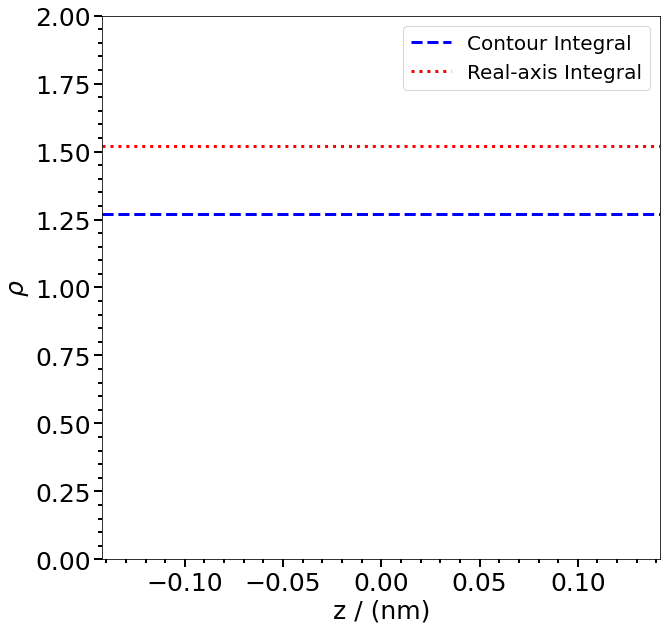

In [380]:
if(PrintFigures):
    plt,pltname = custom_plot_single([axial_loc/nano,axial_loc/nano], 
                       [np.real(Rho_RealIntegral_plus),np.real(Rho_Real)],
                       [r'Contour Integral', r'Real-axis Integral'],
                       [axial_loc[0]/nano,axial_loc[-1]/nano],[0,2],[r'z / (nm)',r'$\rho$'],'charge_density.png',
                       ['b','r'],linestyle=['dashed','dotted'],
                       show_legend=True,
                       plt_outside=True)

    plt.savefig(pltname, bbox_inches = "tight")

In [ ]:
# T=np.zeros(Epts,dtype=float)
# Cond=np.zeros(Epts,dtype=float)
# I=np.zeros(Epts,dtype=float)
# Num=np.zeros(Epts,dtype=float)


# D=np.zeros(Epts,dtype=float)
# A=np.zeros((Epts,N),dtype=float)
# rho=np.zeros(N,dtype=float)

# Cond_tot = 0.
# I_tot=0. #Current
# Num_tot=0
# deltaE=E[1]-E[0]
# print(deltaE)

# for e in range(0,E_total_pts):
#     Sigma_s=np.zeros((M_red*N,M_red*N),dtype=complex)
#     Sigma_d=np.zeros((M_red*N,M_red*N),dtype=complex)
#     Gamma_s=np.zeros((M_red*N,M_red*N),dtype=complex)
#     Gamma_d=np.zeros((M_red*N,M_red*N),dtype=complex)
#     for j in range(0,M_red):
#         Sigma_s[j*N][j*N] = Sigma_s_comp[j][e]
#         Sigma_d[(j+1)*N-1][(j+1)*N-1] = Sigma_d_comp[j][e]
#         Gamma_s[j*N][j*N] = Gamma_s_comp[j][e]
#         Gamma_d[(j+1)*N-1][(j+1)*N-1] = Gamma_d_comp[j][e]

#     G_R_inverse = ((E[e]+zplus)*np.eye(M_red*N))- H - Sigma_s - Sigma_d
#     G_R=inv(G_R_inverse)
#     G_A = G_R.conj().T
#     T[e]=np.real(np.trace(Gamma_s@G_A@Gamma_d@G_R))
#     Cond[e]= -G_quantum*T[e]*dfdE_c[e]
#     Amat=1j*(G_R - G_A)
#     D[e]=np.real(np.trace(Amat)/(2*np.pi))
#     A[e] = np.real(np.diag(Amat))
#     #print(A[0]) 
#     Cond_tot += Cond[e]*deltaE
    
# #     if(e==0):
# #         fig, ax =plt.subplots(2,2,figsize = (12,12))
# #         print('Energy',E[e])
# #         sns.heatmap(np.real(G_R),cmap='coolwarm',annot=True,ax=ax[0][0],label='hey')    
# #         ax[0][0].set_title('Block Tri-diag (Real)')
# #         sns.heatmap(np.imag(G_R),cmap='coolwarm',annot=True,ax=ax[1][0])      
# #         ax[1][0].set_title('Block Tri-diag (Imag)')
# #         sns.heatmap(np.real(G_A@Gamma_d@G_R),cmap='coolwarm',annot=True,ax=ax[0][1])  
# #         ax[0][1].set_title('Python (Real)')
# #         sns.heatmap(np.imag(G_A@Gamma_d@G_R),cmap='coolwarm',annot=True,ax=ax[1][1])  
# #         ax[1][1].set_title('Python (Imag)')    
#     #number of electrons, charge density, and current calculation 
#     Sigma_in_s = Gamma_s * f_s[e]
#     Sigma_in_d = Gamma_d * f_d[e]
#     Sigma_in = Sigma_in_s + Sigma_in_d
#     G_in = G_R@Sigma_in@G_A
#     Rho_mat=G_in/(2*np.pi) #number of electrons per unit energy 
#     rho += np.real(np.diag(Rho_mat))*deltaE
#     Num[e]=np.trace(np.real(Rho_mat))
#     Num_tot += Num[e]*deltaE #Total number of electrons

#     I[e] = (4*q/h)*T[e]*(f_s[e]-f_d[e]) #only applicable to coherent transport
#     I_tot = I[e]*deltaE


In [ ]:
print('N_tot',Num_tot)
print('I_tot',I_tot)

In [ ]:
cpp_E   =  np.zeros(Epts,dtype=float)
cpp_T_r =  np.zeros(Epts,dtype=float)
cpp_T_i =  np.zeros(Epts,dtype=float)

#file = open("cpp_results/cpu/Transmission")
#file = open("cpp_results/1gpu/Transmission")
file = open("cpp_results/8gpu_8kPts/Transmission")

lst = []
counter=0
for line in file:    
    if (counter > 0 and counter < Epts+1):
        lst += [line.split()]
    counter = counter + 1
cpp_E     = [x[0] for x in lst]
cpp_T_r   = [x[1] for x in lst]
cpp_T_i   = [x[2] for x in lst]

cpp_E = np.asfarray(cpp_E)
cpp_T_r = np.asfarray(cpp_T_r)
cpp_T_i = np.asfarray(cpp_T_i)

print(cpp_E[0], cpp_T_r[0], cpp_T_i[0])

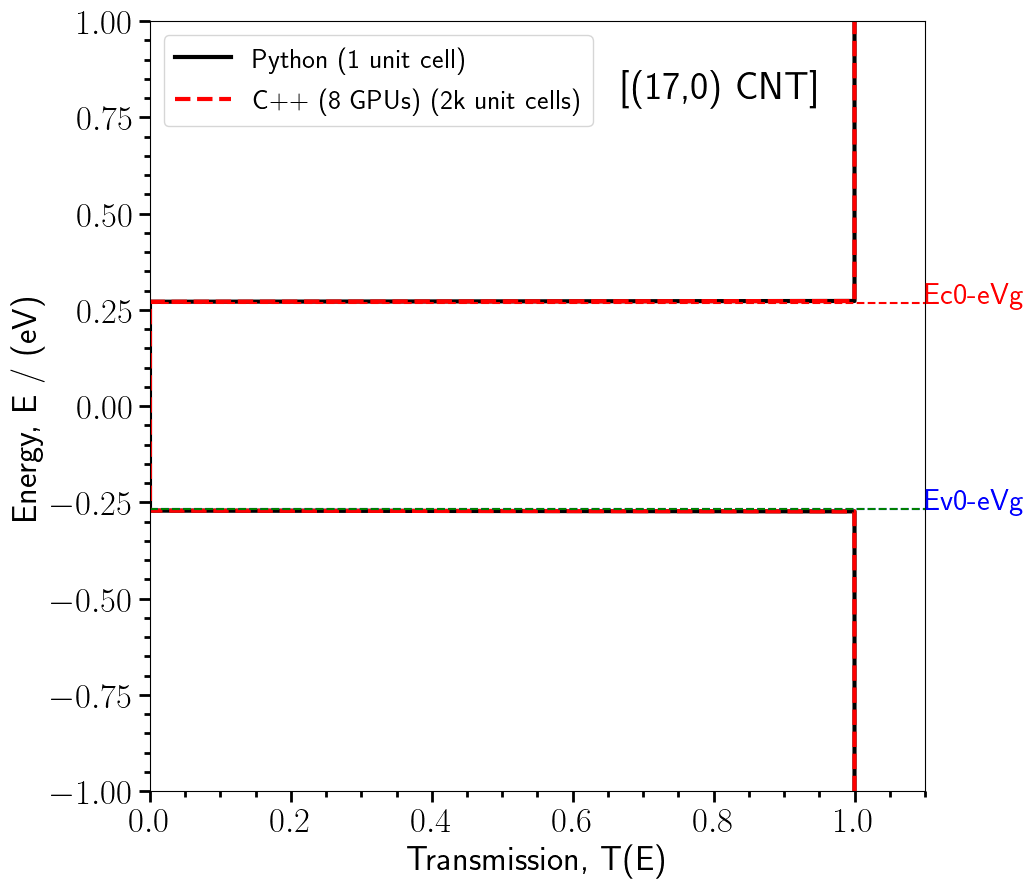

In [141]:
if(PrintFigures):
    plt,pltname=custom_plot_single([T,cpp_T_r], 
                       [E,cpp_E],
                       [r'Python (1 unit cell)', 'C++ (8 GPUs) (2k unit cells)'],
                       [0,1.1],[-1,1],[r'Transmission, T(E)', r'Energy, E / (eV)', 'T'],
                        'Compare_Transmission_%d_%d.png'%(m,n),
                       ['k','r'],
                       ['solid','dashed'],
                       2*[None],
                       2*['none'],
                       [3,3],show_legend=True,plt_outside=True)
    plt.axhline(y = Ev0+U[-1], color = 'b', linestyle = 'dashed',label='Fermi')
    plt.text(1.1, (Ev0+U[-1]), 'Ev0-eVg', fontsize=22,color='b')

    plt.axhline(y = Ec0+U[-1], color = 'r', linestyle = 'dashed',label='Fermi')
    plt.text(1.1, (Ec0+U[-1]), 'Ec0-eVg', fontsize=22,color='r')

    plt.axhline(y = np.min(Ev0+U), color = 'g', linestyle = 'dashed',label='Fermi')
    #plt.text(1.1,  np.min(Ev0+U), 'min(Ev0-U)', fontsize=22,color='g')
    #plt.text(0.5, 0.8, r'T=Trace[$\Gamma_s G^R \Gamma_d G^A$]', fontsize=22,color='k')
    plt.text(0.67, 0.8, '[(%d,%d) CNT]'%(m,n), fontsize=28,color='k')

    plt.savefig(pltname, bbox_inches = "tight")
    

In [73]:
#print(Cond)

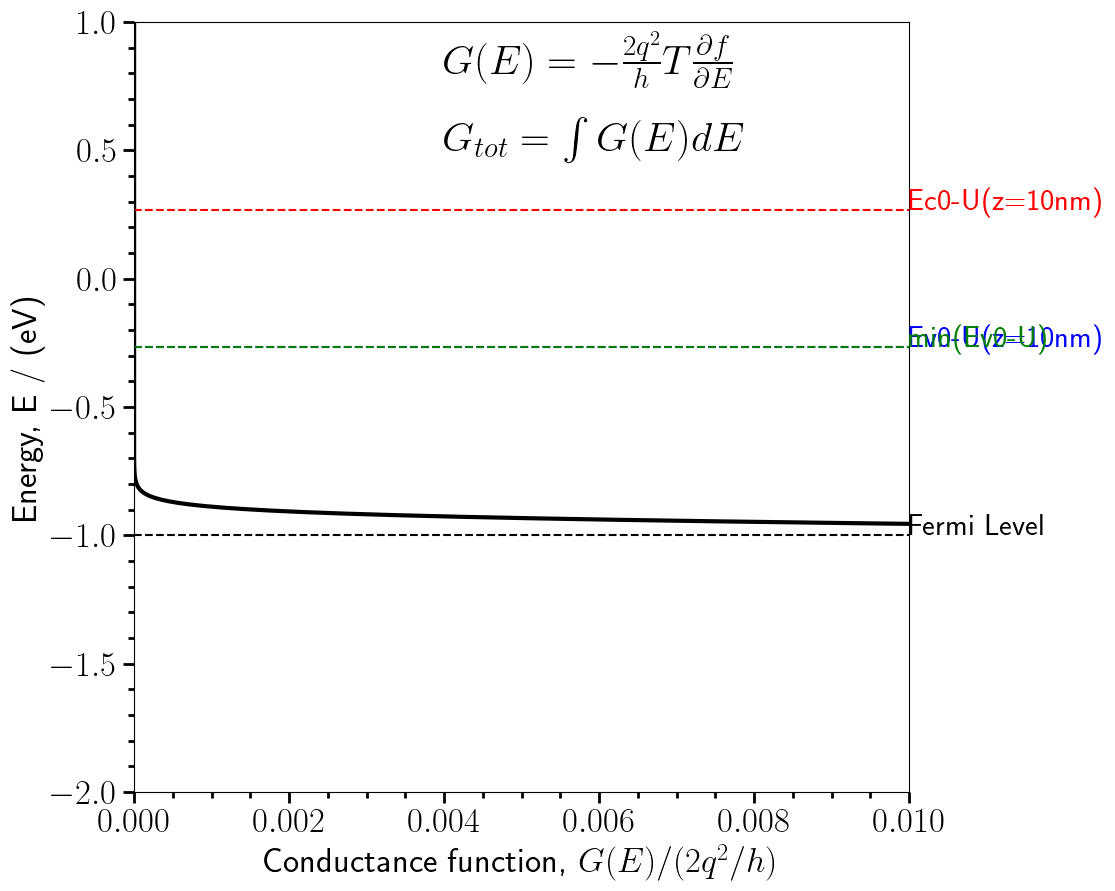

In [74]:
if(PrintFigures):
    plt,pltname=custom_plot_single([Cond/G_quantum], 
                       [E],
                       [r'$(%d,%d)$'%(m,n)],
                       [0,0.01],[-2,1],[r'Conductance function, $G(E)/(2q^2/h)$',r'Energy, E / (eV)'] ,'Conductance_%d_%d.png'%(m,n),
                       ['k'],
                       ['solid'],
                       1*[None],
                       1*['none'],
                       [3],show_legend=False,plt_outside=True)
    plt.axhline(y = Ef, color = 'k', linestyle = 'dashed',label='Fermi')
    plt.text(0.01, Ef, 'Fermi Level', fontsize=22,color='k')
    
    plt.axhline(y = Ev0+U[-1], color = 'b', linestyle = 'dashed',label='Fermi')
    plt.text(0.01, (Ev0+U[-1]), 'Ev0-U(z=10nm)', fontsize=22,color='b')

    plt.axhline(y = Ec0+U[-1], color = 'r', linestyle = 'dashed',label='Fermi')
    plt.text(0.01, (Ec0+U[-1]), 'Ec0-U(z=10nm)', fontsize=22,color='r')

    plt.axhline(y = np.min(Ev0+U), color = 'g', linestyle = 'dashed',label='Fermi')
    plt.text(0.01,  np.min(Ev0+U), 'min(Ev0-U)', fontsize=22,color='g')
    plt.text(0.004, 0.8, r'$G(E)=-\frac{2q^2}{h} T \frac{\partial f}{\partial E}$', fontsize=30,color='k')
    plt.text(0.004, 0.5, r'$G_{tot}=\int G(E) dE$', fontsize=30,color='k')

    plt.savefig(pltname, bbox_inches = "tight")

In [75]:
print('Total conductance:',Cond_tot)

Total conductance: 4.94154210976451e-07


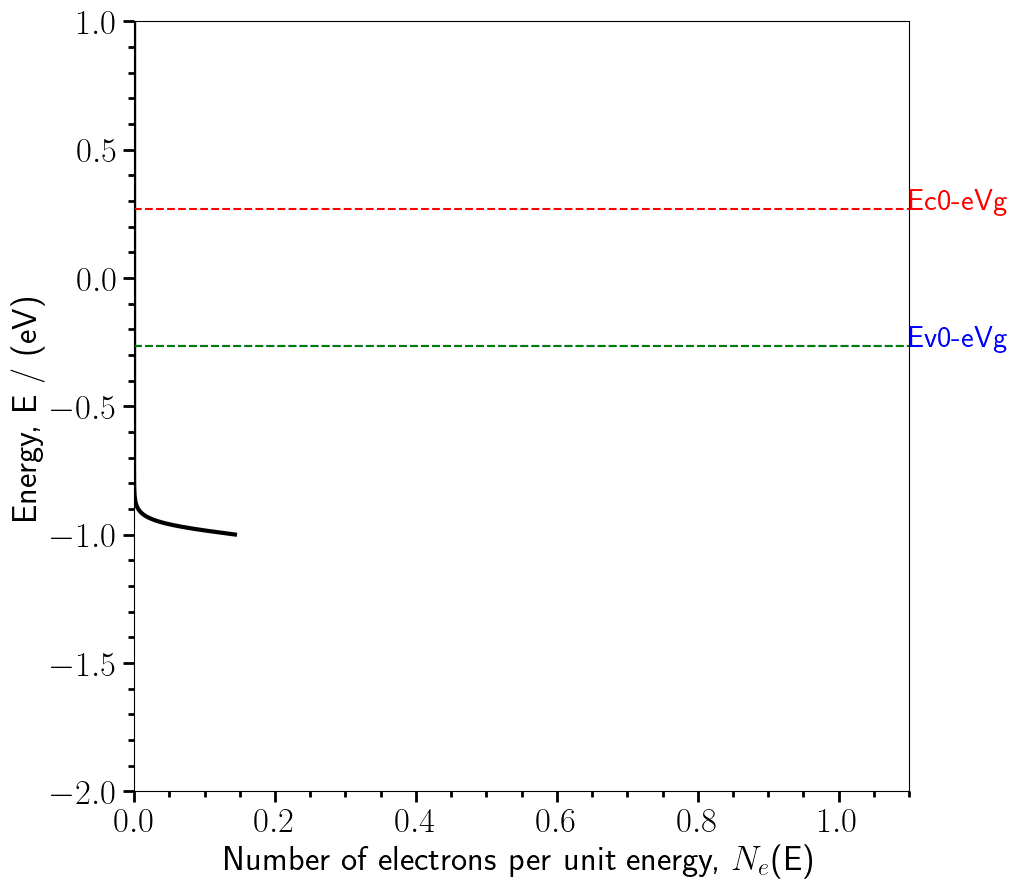

In [76]:
#Num(E)
if(PrintFigures):
    plt,pltname=custom_plot_single([Num], 
                       [E],
                       [r'$I(E) (%d,%d)$'%(m,n)],
                       [0,1.1],[-2,1],[r'Number of electrons per unit energy, $N_e$(E)', r'Energy, E / (eV)', 'T'],'Number_%d_%d.png'%(m,n),
                       ['k'],
                       ['solid'],
                       1*[None],
                       1*['none'],
                       [3],show_legend=False,plt_outside=True)
    plt.axhline(y = Ev0+U[-1], color = 'b', linestyle = 'dashed',label='Fermi')
    plt.text(1.1, (Ev0+U[-1]), 'Ev0-eVg', fontsize=22,color='b')

    plt.axhline(y = Ec0+U[-1], color = 'r', linestyle = 'dashed',label='Fermi')
    plt.text(1.1, (Ec0+U[-1]), 'Ec0-eVg', fontsize=22,color='r')

    plt.axhline(y = np.min(Ev0+U), color = 'g', linestyle = 'dashed',label='Fermi')

    plt.savefig(pltname, bbox_inches = "tight")

4 1000
-0.14199999999999996 0.14200000000000002
[1.e-13 1.e-12 1.e-11 1.e-10 1.e-09 1.e-08 1.e-07 1.e-06 1.e-05 1.e-04
 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01]


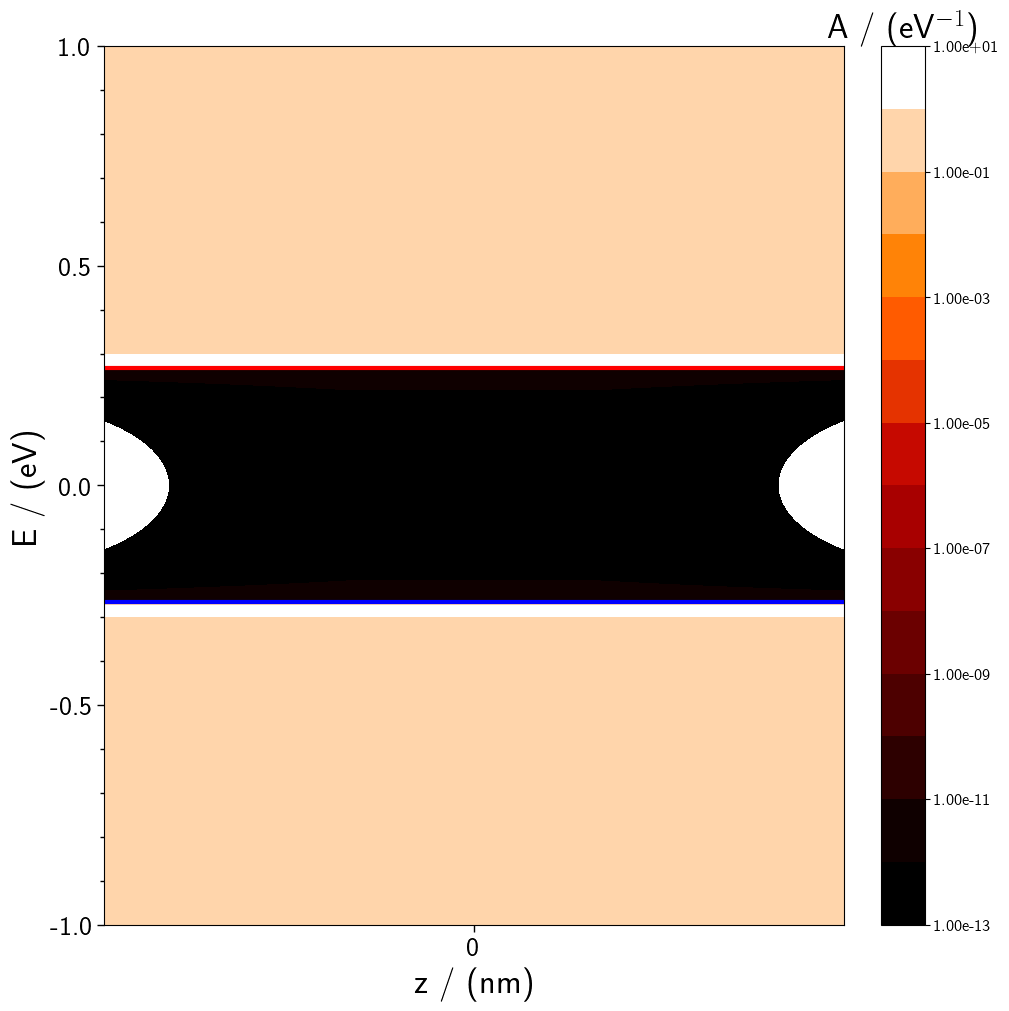

In [78]:
from matplotlib import ticker, cm
import matplotlib.colors as colors
def contourSpanVsTime(contourdata,ContourMin,ContourMax,xarr,yarr,fig, ax,cbarTrue,cbarlabel,
                     x_lst, y_lst, color_lst):
    print(len(xarr),len(yarr))
    print(xarr[0],xarr[-1])
    X, Y = np.meshgrid(len(xarr),len(yarr))
    cmap = plt.get_cmap('gist_heat')
    #levels = MaxNLocator(nbins=20).tick_values(0.0001, ContourMax)
    #levels=levels.astype(float)

    levels_exp = np.arange(np.floor(np.log10(1e-12)-1),np.ceil(np.log10(ContourMax)+1))
    levels = np.power(10, levels_exp)
    print(levels)
    extent=[xarr[0],xarr[-1],yarr[0],yarr[-1]]

    cpl=ax.contourf(contourdata,extent=extent,levels=levels,
                    norm=colors.LogNorm(vmin=1e-12, vmax=ContourMax),
                    cmap=cmap)
    for p in range(0, len(x_lst)):
        ax.plot(x_lst[p], y_lst[p], color_lst[p],linewidth=3,linestyle='solid')
#    ax.clabel(cpl, inline=True, fontsize=15,fmt='%.1e',colors='r')
    if (cbarTrue==True):
        cbar = fig.colorbar(cpl,ax=ax,format='%.2e')
        #cbar.minorticks_on()
        cbar.ax.set_title(cbarlabel,fontsize = 25,weight="bold")

    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.tick_params(which='minor', length=3, color='black',width=1)
    ax.tick_params(which='major', length=5, color='black',width=1)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)

    return plt

from matplotlib import rc, rcParams
rc('text', usetex=True)

fig, ax = plt.subplots(1,1, constrained_layout=True)
fig.set_size_inches(10,10)

xe=N
ye=Epts
myplt1=contourSpanVsTime(A,A.min(),A.max(),axial_loc/nano,E,fig, ax, cbarTrue=True,cbarlabel=r'A / (eV$^{-1}$)',
                         x_lst=[axial_loc/nano,axial_loc/nano], 
                         y_lst=[Ev0+U, Ec0+U],
                         color_lst=['b','r'])
ax.set_xlabel(r'z / (nm)',fontsize=25)
ax.set_ylabel(r'E / (eV)',fontsize=25)
plt.savefig('SpectralFunction.png', bbox_inches = "tight")


In [79]:
#print(D)

# Comparison with Mintmire & White (Theory and First principles)

In [80]:
nu0=np.round(2*m/3)
print(nu0+M)
#Mode_arr_Mintmire=np.linspace(-M,M,2*M+1)
Mode_arr_Mintmire=np.linspace(-M,M,2*M+1)

#Mode_arr_datta=np.linspace(nu0-M,nu0+M,2*M+1)
print('Mode_arr_Mintmire',Mode_arr_Mintmire)
#print('Mode_arr_datta',Mode_arr_datta)

Lambda_Mintmire = 2*R/acc
print('Lambda_Mintmire',Lambda_Mintmire)

print('sorted_M_arr',sorted_M_arr)

28.0
Mode_arr_Mintmire [-17. -16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.
  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.
  11.  12.  13.  14.  15.  16.  17.]
Lambda_Mintmire 9.372591222170465
sorted_M_arr [6, 11, 5, 12, 7, 10, 4, 13, 8, 9, 3, 14, 2, 15, 1, 16, 17]


In [81]:
##Francois' book
D_th_lin = np.zeros(Epts, dtype=float)

for e in range(0,Epts):
    const = acc*np.sqrt(3)/(np.pi**2*R*gamma)
    Sum=0.
    for nu in Mode_arr_Mintmire:   
        eps_m = np.abs(3*nu-m+n)*acc*gamma/(2*R) 
        if(np.abs(E[e]) > np.abs(eps_m)):
            Sum += np.abs(E[e])/cmath.sqrt(E[e]**2 - eps_m**2)
        elif(np.abs(E[e]) < np.abs(eps_m)):
            Sum +=0
    D_th_lin[e] = const*np.real(Sum)#*num_atoms

dE_dk = np.zeros((M,np.size(k)),dtype=float)
for p in range(1,M+1):
    dE_dk[p-1] = np.gradient(E_k[p*2-2])
    
# D_th = np.zeros(Epts, dtype=float)   
# for e in range(0,Epts):
#     print('e',e)
#     const = acc**2*np.sqrt(3)/(np.pi**2*R)
#     Sum=0.+1j*0.
#     for p in range(1,M+1):
#         #print(p)
#         k_sum=0.
#         for kx in range(0,np.size(k)):
#             convergence=np.abs((np.abs(E[e])-np.abs(E_k[p*2-2][kx]))/E[e])
#             if(convergence < 1e-3): 
#                 k_sum += 1./(np.abs(dE_dk[p-1][kx]))
#                 if(np.abs(dE_dk[p-1][kx])==0):
#                     print('mode, convergence, E, E(k)', sorted_M_arr[p-1], convergence, E[e],E_k[p*2-2][kx])
#             else:
#                 k_sum=0.
#         Sum += k_sum*(k[1]-k[0])
#     D_th[e] = const*np.real(Sum)


###Supriyo Datta's
#
# D_th_datta = np.zeros(Epts, dtype=float)

# for e in range(0,Epts):
#     a=3*acc/2.
#     L=1*(3/4)*acc/17
#     const = (2*L/(np.pi*a*gamma))
#     Sum=0.
#     for nu in Mode_arr_datta:
#         Ek = (gamma*2*np.pi/np.sqrt(3))*(3*nu/(2*m)-1)+1j*1e-12
#         Sum += E[e]/cmath.sqrt(E[e]**2 - Ek**2)
        
#     D_th_datta[e] = const*Sum

In [82]:
# if(PrintFigures):
#     custom_plot_single([Lambda_Mintmire*E/gamma,Lambda_Mintmire*E/gamma], 
#                        [Lambda_Mintmire*gamma*D*2/M/N,Lambda_Mintmire*gamma*D_th_lin],
#                        [r'NEGF [(%d,%d) CNT]'%(m,n), r'Mintmire & White (Theory)'],
#                        [-5,5],[0,10],[r'Normalized energy, $\Lambda E$ / $\gamma$',r'Normalized Density of States, $\Lambda \gamma D(E)$'],'DOS_Normalized_%d_%d.png'%(m,n),
#                        ['k','r','b'],
#                        ['solid','dashed','dotted'],
#                        3*[None],
#                        3*['none'],
#                        3*[3])

In [142]:
cpp_E     =  np.zeros(Epts,dtype=float)
cpp_DOS_r =  np.zeros(Epts,dtype=float)
cpp_DOS_i =  np.zeros(Epts,dtype=float)

#file = open("cpp_results/cpu/DOS")
#file = open("cpp_results/1gpu/DOS")
file = open("cpp_results/8gpu_8kPts/DOS")


lst = []
counter=0
for line in file:    
    if (counter > 0 and counter < Epts+1):
        lst += [line.split()]
    counter = counter + 1
cpp_E     = [x[0] for x in lst]
cpp_DOS_r = [x[1] for x in lst]
cpp_DOS_i = [x[2] for x in lst]

cpp_E = np.asfarray(cpp_E)
cpp_DOS_r = np.asfarray(cpp_DOS_r)
cpp_DOS_i = np.asfarray(cpp_DOS_i)

print(cpp_E[0], cpp_DOS_r[0], cpp_DOS_i[0])

-1.0 572.439 -4.47942e-13


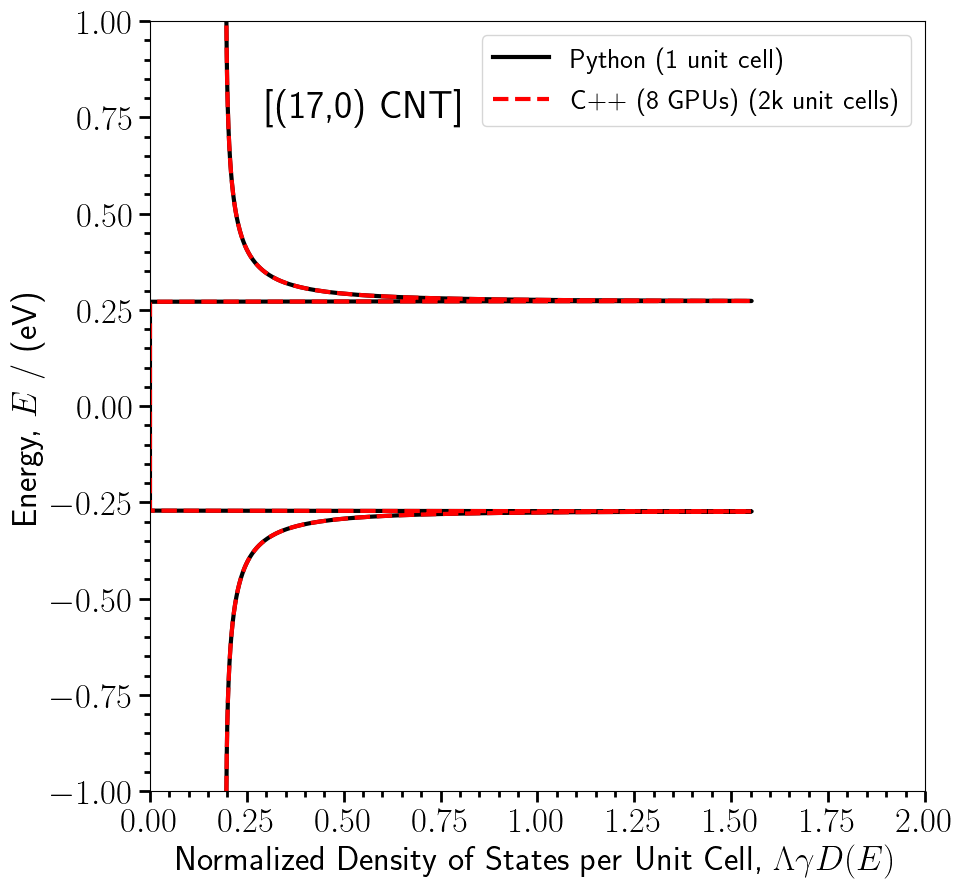

In [146]:
if(PrintFigures):
    plt,pltname = custom_plot_single([Lambda_Mintmire*gamma*D*2/M/N,
                                      Lambda_Mintmire*gamma*cpp_DOS_r*2/M/N/2000],
                                     [E,cpp_E], 
                       [r'Python (1 unit cell)', 'C++ (8 GPUs) (2k unit cells)'],
                       [0,2],[-1,1],[r'Normalized Density of States per Unit Cell, $\Lambda \gamma D(E)$',r'Energy, $E$ / (eV)'],
                       'Compare_DOS_%d_%d.png'%(m,n),
                       ['k','r','b'],
                       ['solid','dashed','dotted'],
                       3*[None],
                       3*['none'],
                       3*[3], plt_outside=True)
    plt.text(0.3, 0.75, '[(%d,%d) CNT]'%(m,n), fontsize=28,color='k')
    #plt.text(0.3, 1, 'point charge= %de'%(Q/q), fontsize=22,color='k')

    plt.savefig(pltname, bbox_inches = "tight")

In [ ]:
def get_bandgap_from_DOS(E, Dnorm):
    Epts = np.size(E)
    e_plus_traverse = True
    e_minus_traverse = True
    e_plus = 0.
    e_minus = 0.
    bandgap = 0.
    if(Dnorm[int(Epts/2.)] > 1e-3):
        bandgap = 0. 
    else:
        for e in range(int(Epts/2.), Epts):
            if(e_plus_traverse):
                if(E[e] > 0.):
                    if(Dnorm[e] > 0.1):
                        e_plus = E[e]
                        e_plus_traverse = False
                        break
                
        for e in np.arange(int(Epts/2.), 0,-1):
            if(e_minus_traverse):
                if(E[e] < 0.):
                    if(Dnorm[e] > 0.1):
                        e_minus = E[e]
                        e_minus_traverse = False
                        break
                        print(E[e],D[e])
        bandgap = e_plus - e_minus
    return bandgap

bandgap_negf = get_bandgap_from_DOS(E, Lambda_Mintmire*gamma*D*2/M/N )
print('m, n, bandgap_negf, bandgap_theory: ', m, n, bandgap_negf, Eg_min)